In [15]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_tree_leafs_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics
from tasks.boston_housing import make_task3 as make_task

In [3]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [ ]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'diro2c-data/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

This was run on a different machine (Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz):
- (0, 0)... 0:09:14.121881
- (0, 1)... 0:18:27.296837
- (0, 2)... 0:27:39.069402
- (1, 0)... 0:36:50.820186
- (1, 1)... 0:46:05.013733
- (1, 2)... 0:55:17.436635
- (2, 0)... 1:04:28.611089
- (2, 1)... 1:13:41.226071
- (2, 2)... 1:22:54.833047

## $(0,1)$

In [12]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [13]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

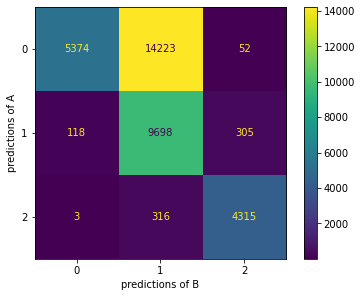

In [16]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston3-diro2c-cf-01.pdf')

In [17]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 2min 36s, sys: 1.17 s, total: 2min 37s
Wall time: 2min 44s


653

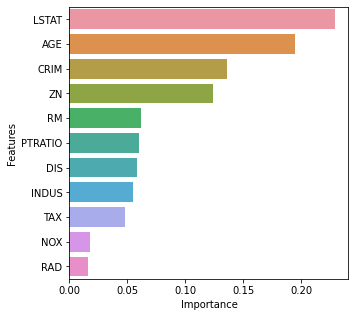

In [18]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

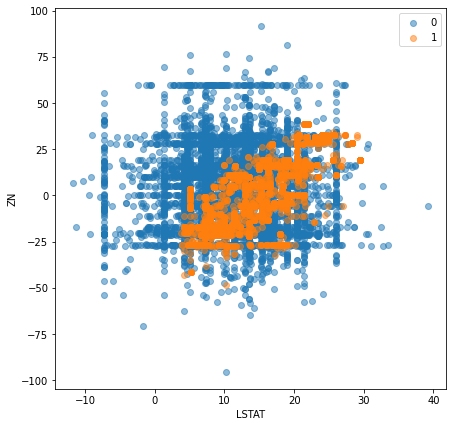

In [19]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [20]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.044378366605484054, 1, 2)

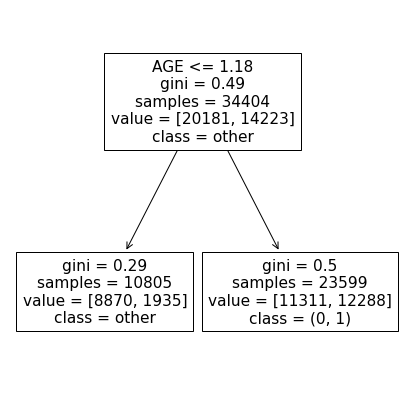

In [21]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [22]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.1843945980072021 => (0, 1) [11311, 12288]


### 3 Leafs

In [23]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01675494340039045, 2, 3)

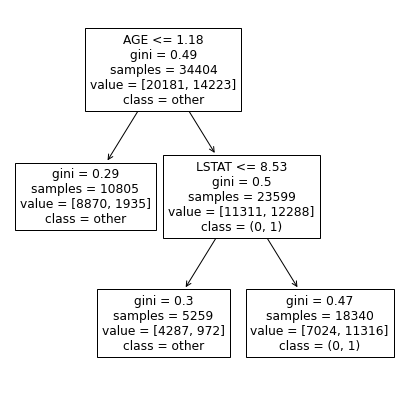

In [24]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [25]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.1843945980072021 and LSTAT > 8.526278495788574 => (0, 1) [7024, 11316]


### 5 Leafs

In [26]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.015781829512449996, 4, 5)

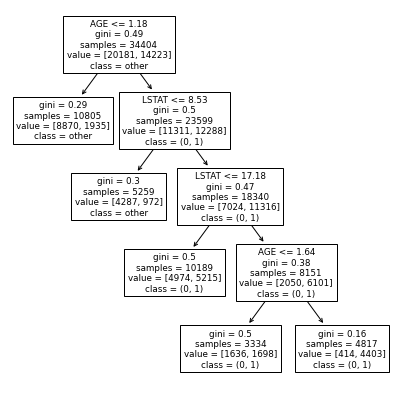

In [27]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [28]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.1843945980072021 and 8.526278495788574 < LSTAT <= 17.183279037475586 => (0, 1) [4974, 5215]
2. AGE > 1.6383781433105469 and LSTAT > 17.183279037475586 => (0, 1) [414, 4403]
3. 1.1843945980072021 < AGE <= 1.6383781433105469 and LSTAT > 17.183279037475586 => (0, 1) [1636, 1698]


### 6 Leafs

In [29]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.014269193938039867, 4, 6)

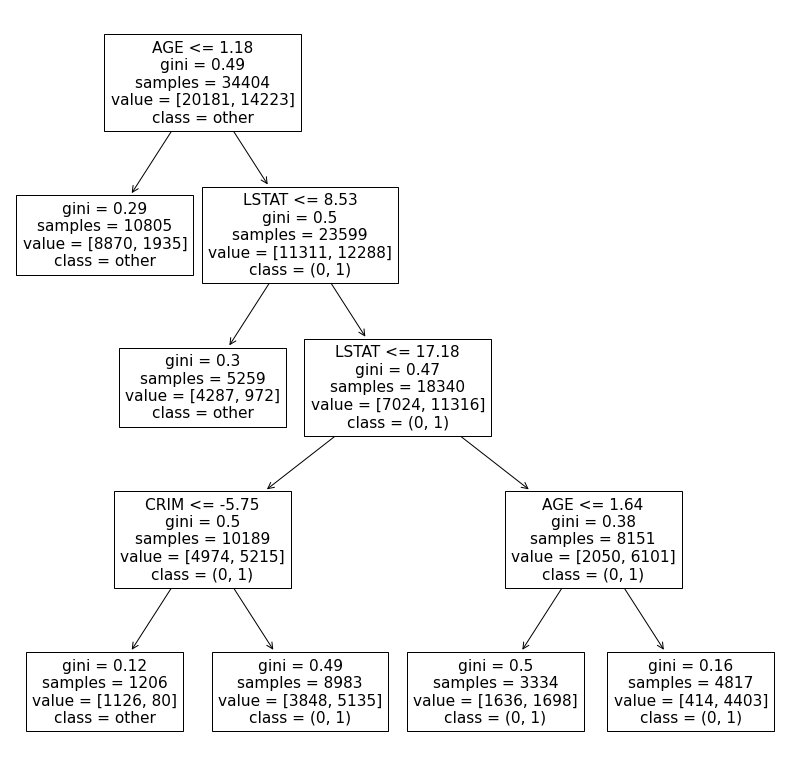

In [30]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [31]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM > -5.749989032745361 and AGE > 1.1843945980072021 and 8.526278495788574 < LSTAT <= 17.183279037475586 => (0, 1) [3848, 5135]
2. AGE > 1.6383781433105469 and LSTAT > 17.183279037475586 => (0, 1) [414, 4403]
3. 1.1843945980072021 < AGE <= 1.6383781433105469 and LSTAT > 17.183279037475586 => (0, 1) [1636, 1698]


## $(1,0)$

In [32]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [33]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

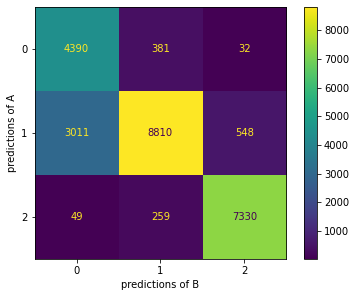

In [34]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston3-diro2c-cf-10.pdf')

In [35]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 9.89 s, sys: 101 ms, total: 9.99 s
Wall time: 10.8 s


92

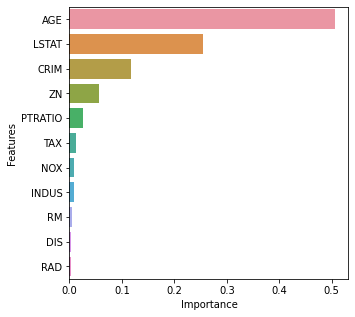

In [36]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

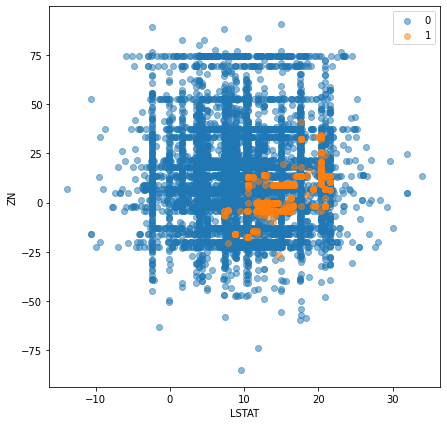

In [37]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [38]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.03780738821535676, 1, 2)

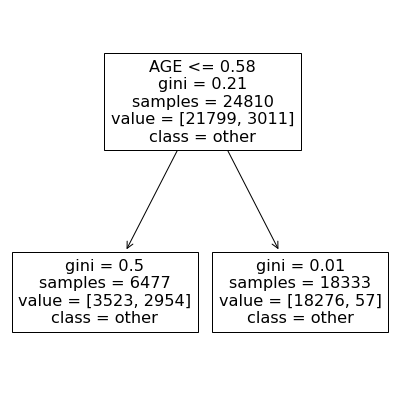

In [39]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [40]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

### 3 Leafs

In [41]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02347633831479074, 2, 3)

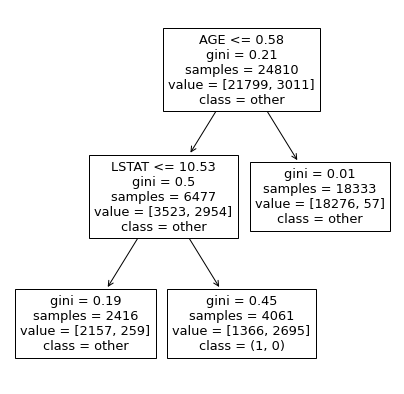

In [42]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [43]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.5808698236942291 and LSTAT > 10.53446912765503 => (1, 0) [1366, 2695]


### 4 Leafs

In [44]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01085149476388473, 3, 4)

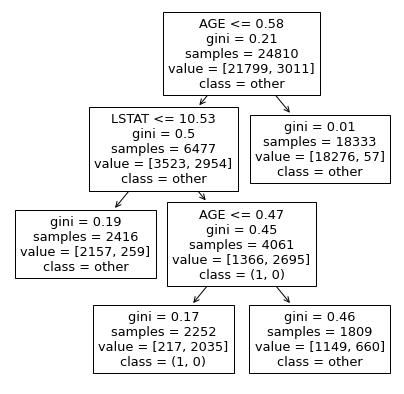

In [45]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [46]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.46873947978019714 and LSTAT > 10.53446912765503 => (1, 0) [217, 2035]


### 4 Leafs

In [47]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008968519234852548, 4, 5)

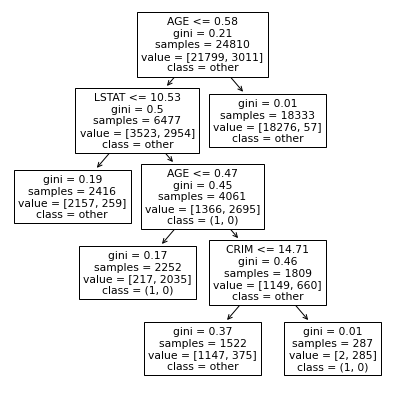

In [48]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [49]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.46873947978019714 and LSTAT > 10.53446912765503 => (1, 0) [217, 2035]
2. CRIM > 14.707335948944092 and 0.46873947978019714 < AGE <= 0.5808698236942291 and LSTAT > 10.53446912765503 => (1, 0) [2, 285]


## $(1,2)$

In [50]:
focus_class = '(1, 2)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [51]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

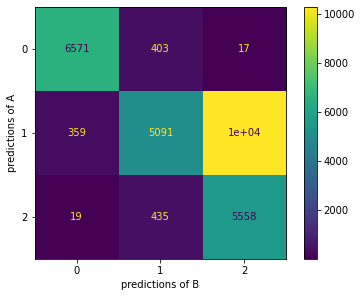

In [52]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston3-diro2c-cf-12.pdf')

In [53]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 51.2 s, sys: 394 ms, total: 51.6 s
Wall time: 54.8 s


302

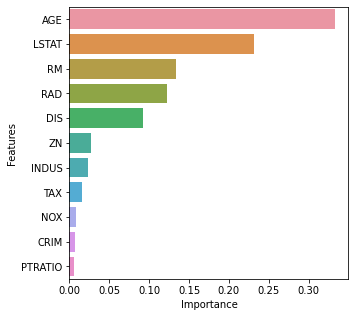

In [54]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

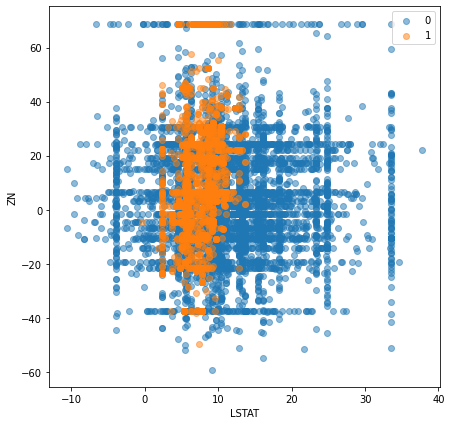

In [55]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [63]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030941635049819644, 1, 2)

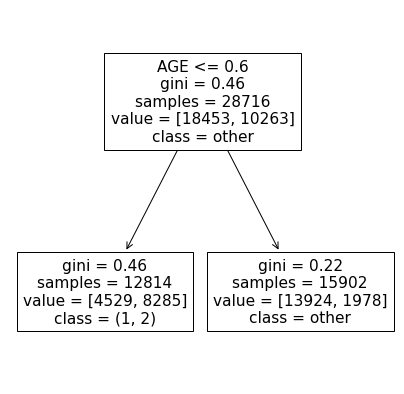

In [64]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [65]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.6028804183006287 => (1, 2) [4529, 8285]


### 5 Leafs

In [66]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030466524102793414, 3, 5)

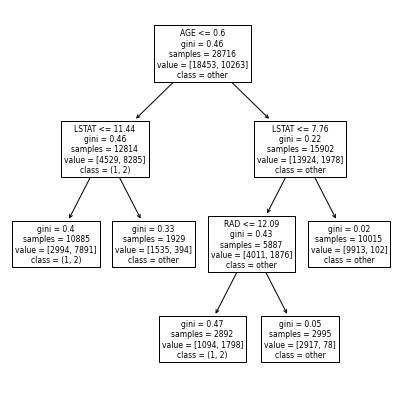

In [67]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [68]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.6028804183006287 and LSTAT <= 11.4449143409729 => (1, 2) [2994, 7891]
2. AGE > 0.6028804183006287 and RAD <= 12.094196319580078 and LSTAT <= 7.759928941726685 => (1, 2) [1094, 1798]


### 6 Leafs

In [69]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.013992509394097727, 3, 6)

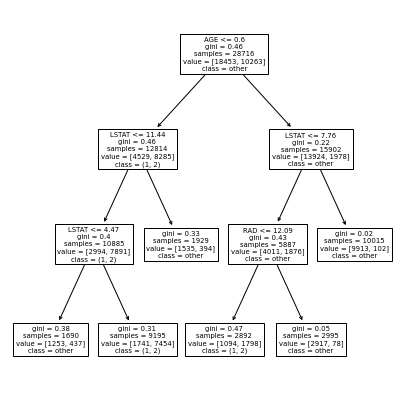

In [70]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [71]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.6028804183006287 and 4.46726131439209 < LSTAT <= 11.4449143409729 => (1, 2) [1741, 7454]
2. AGE > 0.6028804183006287 and RAD <= 12.094196319580078 and LSTAT <= 7.759928941726685 => (1, 2) [1094, 1798]


### 7 Leafs

In [72]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.013874412917507555, 4, 7)

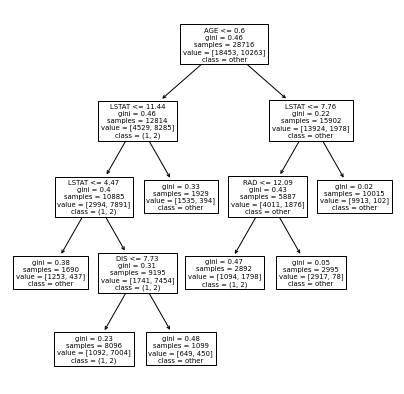

In [73]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [74]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.6028804183006287 and DIS <= 7.732871055603027 and 4.46726131439209 < LSTAT <= 11.4449143409729 => (1, 2) [1092, 7004]
2. AGE > 0.6028804183006287 and RAD <= 12.094196319580078 and LSTAT <= 7.759928941726685 => (1, 2) [1094, 1798]


### 8 Leafs

In [75]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01293236810916172, 4, 8)

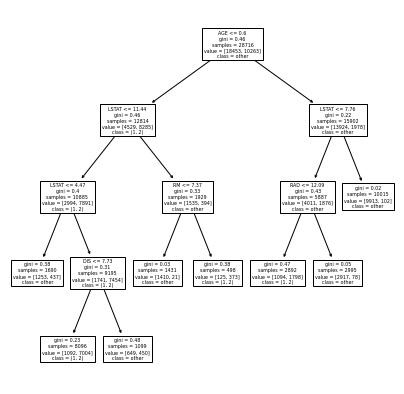

In [76]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [77]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.6028804183006287 and DIS <= 7.732871055603027 and 4.46726131439209 < LSTAT <= 11.4449143409729 => (1, 2) [1092, 7004]
2. AGE > 0.6028804183006287 and RAD <= 12.094196319580078 and LSTAT <= 7.759928941726685 => (1, 2) [1094, 1798]
3. RM > 7.374352931976318 and AGE <= 0.6028804183006287 and LSTAT > 11.4449143409729 => (1, 2) [125, 373]


### 9 Leafs

In [78]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.009812879938153083, 4, 9)

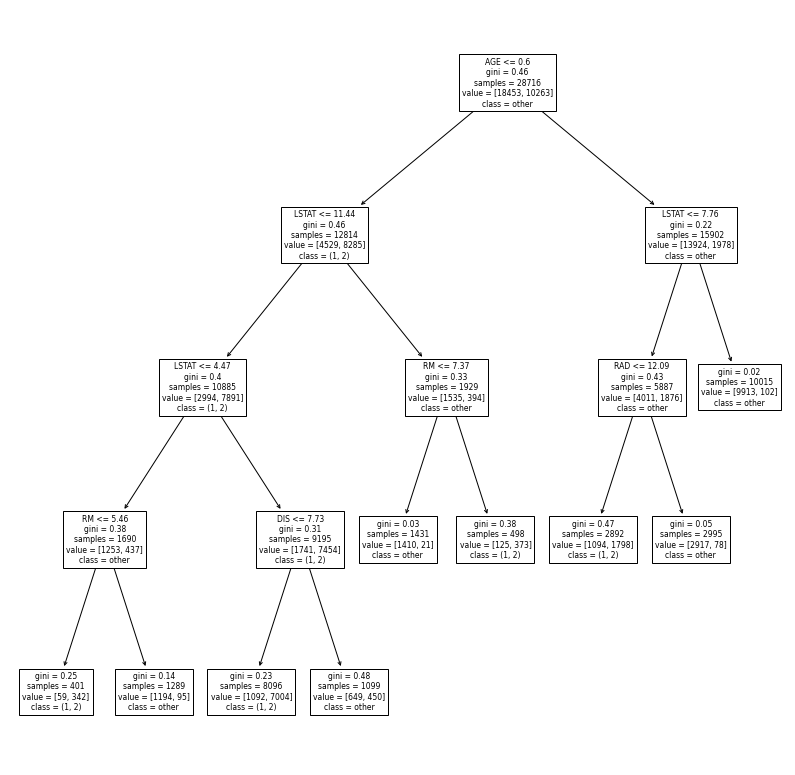

In [81]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [80]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE <= 0.6028804183006287 and DIS <= 7.732871055603027 and 4.46726131439209 < LSTAT <= 11.4449143409729 => (1, 2) [1092, 7004]
2. AGE > 0.6028804183006287 and RAD <= 12.094196319580078 and LSTAT <= 7.759928941726685 => (1, 2) [1094, 1798]
3. RM > 7.374352931976318 and AGE <= 0.6028804183006287 and LSTAT > 11.4449143409729 => (1, 2) [125, 373]
4. RM <= 5.464966773986816 and AGE <= 0.6028804183006287 and LSTAT <= 4.46726131439209 => (1, 2) [59, 342]


## $(2,1)$

In [82]:
focus_class = '(2, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [83]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

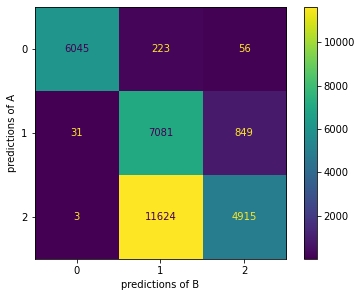

In [84]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston3-diro2c-cf-21.pdf')

In [85]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 1min 25s, sys: 540 ms, total: 1min 26s
Wall time: 1min 29s


417

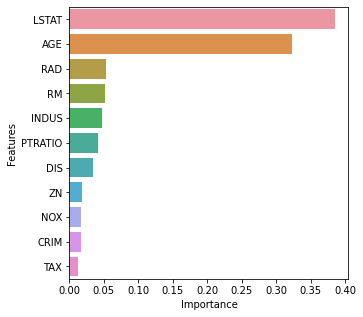

In [86]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

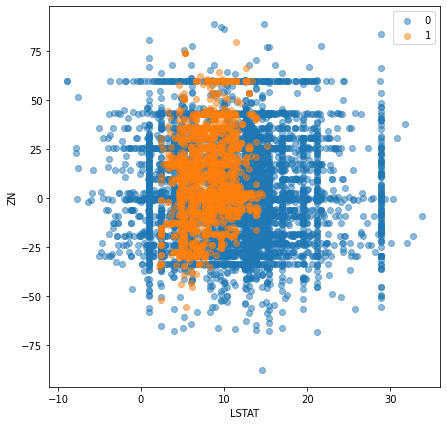

In [87]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [88]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0885841446472844, 1, 2)

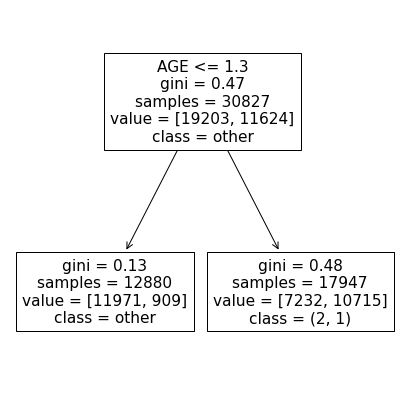

In [89]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [90]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.2982683181762695 => (2, 1) [7232, 10715]


### 3 Leafs

In [91]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030886947219099264, 2, 3)

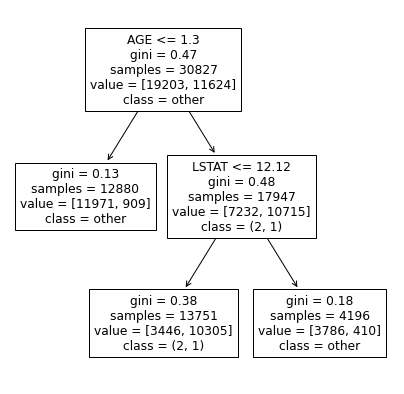

In [92]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [93]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.2982683181762695 and LSTAT <= 12.120173454284668 => (2, 1) [3446, 10305]


### 4 Leafs

In [94]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.014983075509264102, 3, 4)

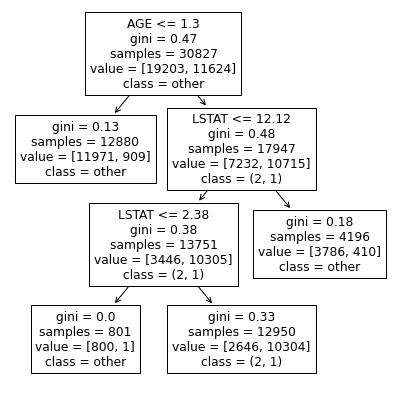

In [95]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [96]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.2982683181762695 and 2.379812002182007 < LSTAT <= 12.120173454284668 => (2, 1) [2646, 10304]


### 5 Leafs

In [97]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.013982447142295313, 4, 5)

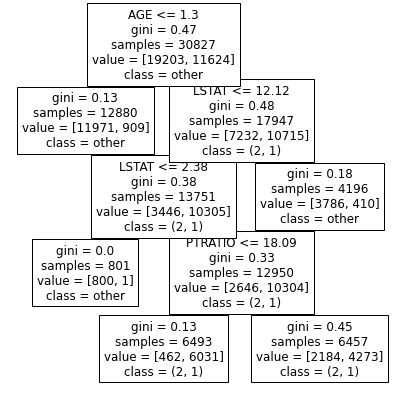

In [98]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [99]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.2982683181762695 and PTRATIO <= 18.085150718688965 and 2.379812002182007 < LSTAT <= 12.120173454284668 => (2, 1) [462, 6031]
2. AGE > 1.2982683181762695 and PTRATIO > 18.085150718688965 and 2.379812002182007 < LSTAT <= 12.120173454284668 => (2, 1) [2184, 4273]


### 7 Leafs

In [100]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008039953885020015, 4, 7)

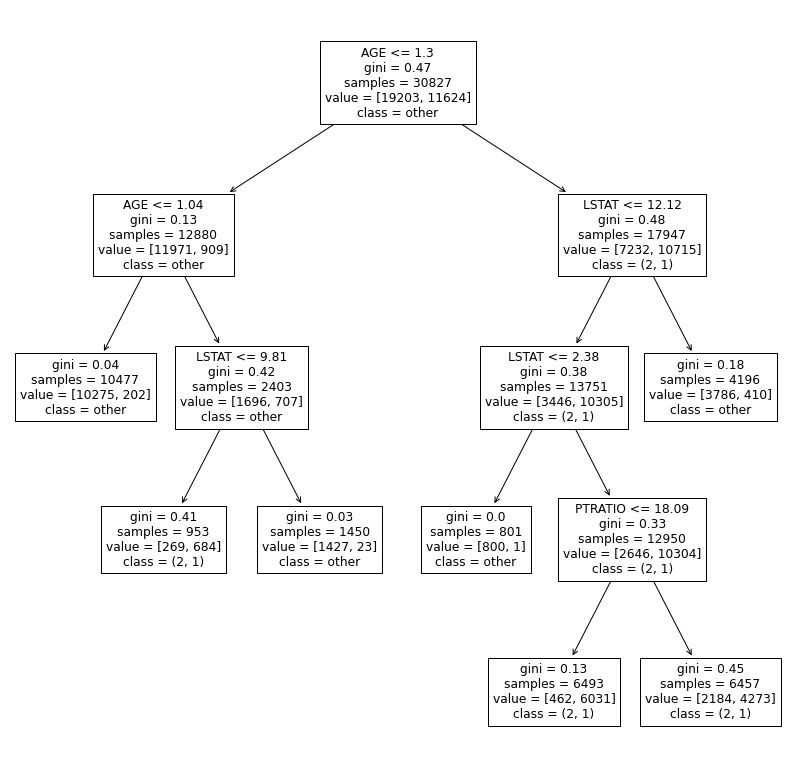

In [103]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [102]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. AGE > 1.2982683181762695 and PTRATIO <= 18.085150718688965 and 2.379812002182007 < LSTAT <= 12.120173454284668 => (2, 1) [462, 6031]
2. AGE > 1.2982683181762695 and PTRATIO > 18.085150718688965 and 2.379812002182007 < LSTAT <= 12.120173454284668 => (2, 1) [2184, 4273]
3. 1.039650559425354 < AGE <= 1.2982683181762695 and LSTAT <= 9.814823627471924 => (2, 1) [269, 684]
